In [1]:
#Data preparation

In [ ]:
import pandas as pd
#load wiki data with summary for KC
kc_wiki_with_summary = pd.read_csv('../../data/data_wiki_clustering/kc_wiki_with_summary.csv')
import pandas as pd
#load wiki data with summary for KC
kc_wiki_with_summary = pd.read_csv('../../data/data_wiki_clustering/kc_wiki_with_summary.csv')
kc_wiki_with_summary
#pre-process data
#reference for gensim library https://www.kaggle.com/code/venkatkrishnan/gensim-text-mining-techniques
#https://radimrehurek.com/gensim/parsing/preprocessing.html
pd.set_option('display.max_colwidth', 1)
import gensim
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, strip_punctuation, remove_stopwords, strip_short
transform_to_lower = lambda s: s.lower()
filters = [strip_tags,
          transform_to_lower,
          strip_punctuation,
          strip_multiple_whitespaces,
          remove_stopwords,
          strip_short
          ]

def cleaning_text(text):
    clean_text = preprocess_string(text, filters)
    return clean_text

kc_wiki_with_summary['clean_summary'] = kc_wiki_with_summary['page_summary'].apply(cleaning_text)


In [ ]:
#DBSCAN clustering

C:\Users\smn18\AppData\Roaming\Python\Python311\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


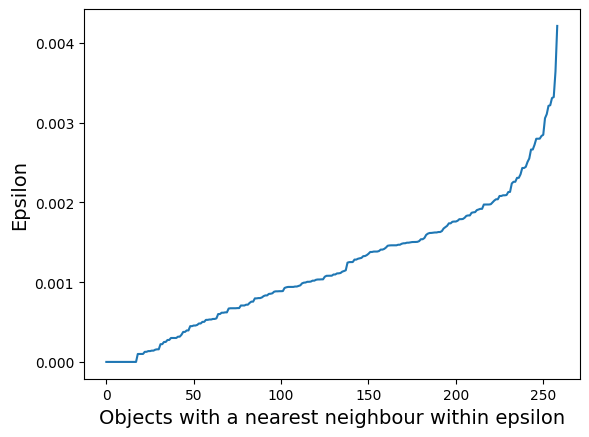

In [2]:
from shapely.geometry import MultiPoint
#load data
kc_coords = kc_wiki_with_summary[['gt_lon', 'gt_lat']].to_numpy()
#finding the optimum epsilon
import numpy as np
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
neighbors = NearestNeighbors(n_neighbors=6)
neighbors_fit = neighbors.fit(kc_coords)
distances, indices = neighbors_fit.kneighbors(kc_coords)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.xlabel('Objects with a nearest neighbour within epsilon', fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.plot(distances)

In [3]:
#run dbscan
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
#run dbscan clustering
dbscan = DBSCAN(eps=0.0020, min_samples=5)
kc_dbscan = dbscan.fit(kc_coords)
#get the labels of clustering
dbscan_labels = kc_dbscan.labels_
dbscan_labels
print('no. of clusters:', len(np.unique(dbscan_labels)))
print('no of noise:', np.sum(np.array(dbscan_labels) == -1, axis=0))
#add cluster labels to dataset
kc_wiki_with_summary['cluster'] = dbscan_labels

no. of clusters: 15
no of noise: 130


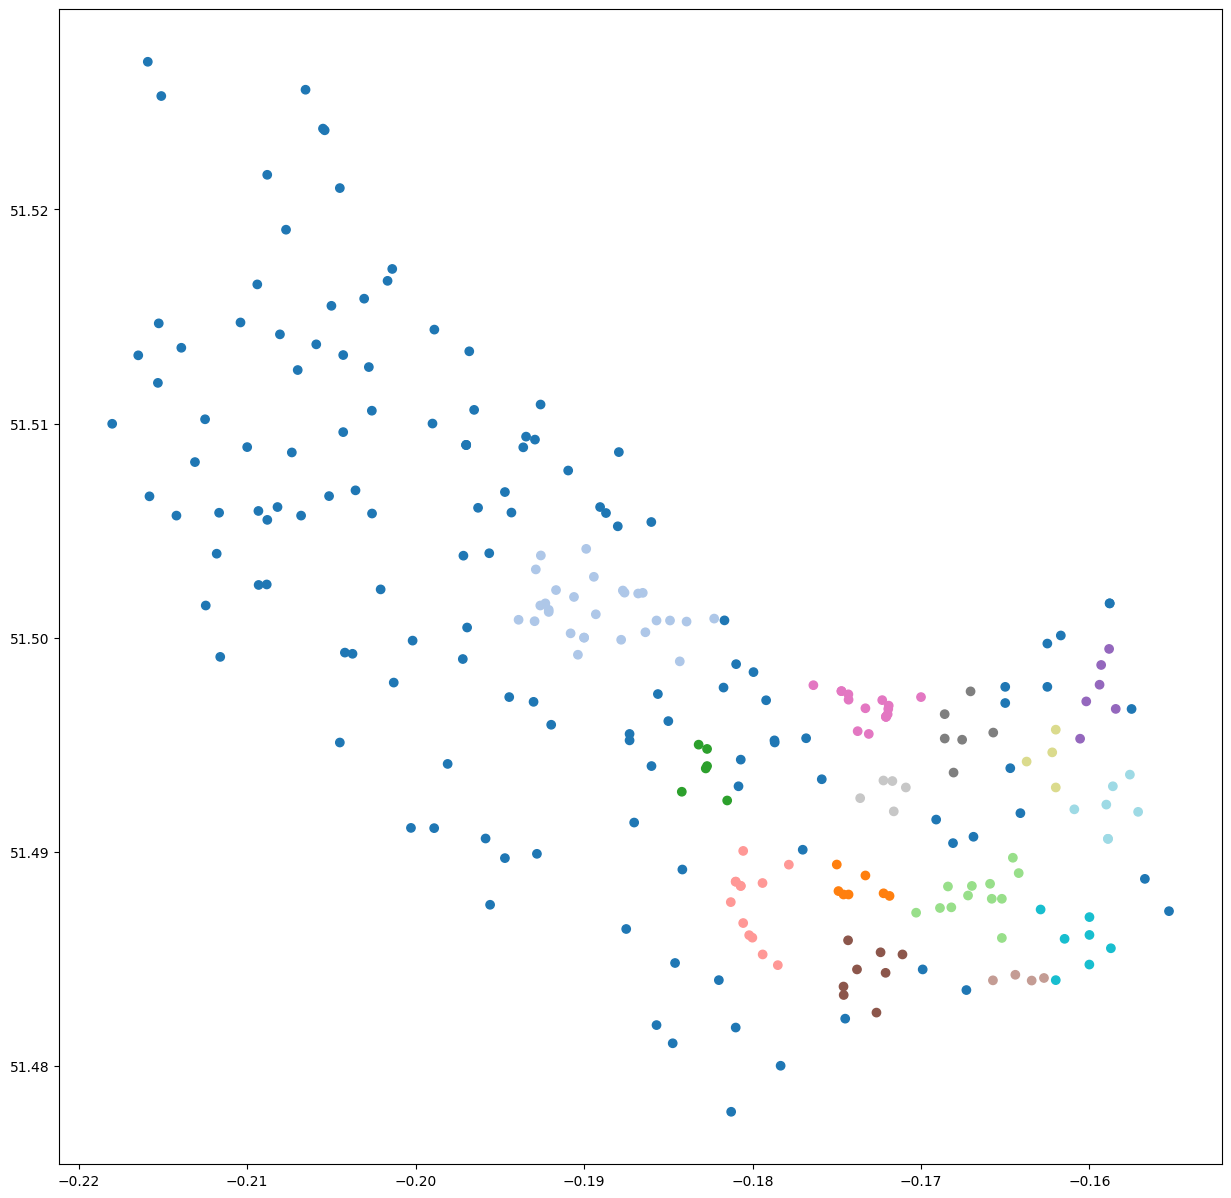

In [4]:
import matplotlib.pyplot as plt
#plot dbscan
plt.figure(figsize=(15, 15))
plt.scatter(kc_wiki_with_summary['gt_lon'], kc_wiki_with_summary['gt_lat'], 
            c=kc_wiki_with_summary['cluster'], 
            cmap='tab20')
#plt.savefig('../../docs/docs_wiki_clustering/dbscan_wiki_kc.png')
plt.show()

[<POLYGON ((-0.184 51.499, -0.19 51.499, -0.194 51.501, -0.193 51.503, -0.193...>, <POLYGON ((-0.172 51.488, -0.175 51.488, -0.175 51.488, -0.175 51.489, -0.17...>, <POLYGON ((-0.182 51.492, -0.184 51.493, -0.183 51.495, -0.183 51.495, -0.18...>, <POLYGON ((-0.165 51.486, -0.17 51.487, -0.168 51.488, -0.165 51.49, -0.164 ...>, <POLYGON ((-0.178 51.485, -0.179 51.485, -0.18 51.486, -0.181 51.488, -0.181...>, <POLYGON ((-0.161 51.495, -0.16 51.497, -0.159 51.499, -0.159 51.499, -0.158...>, <POLYGON ((-0.173 51.482, -0.175 51.483, -0.175 51.484, -0.174 51.486, -0.17...>, <POLYGON ((-0.163 51.484, -0.166 51.484, -0.164 51.484, -0.163 51.484, -0.16...>, <POLYGON ((-0.173 51.496, -0.174 51.496, -0.176 51.498, -0.17 51.497, -0.173...>, <POLYGON ((-0.168 51.494, -0.169 51.495, -0.169 51.496, -0.167 51.497, -0.16...>, <POLYGON ((-0.172 51.492, -0.174 51.492, -0.172 51.493, -0.172 51.493, -0.17...>, <POLYGON ((-0.162 51.493, -0.164 51.494, -0.162 51.496, -0.162 51.493))>, <POLYGON ((-0.162 51.48

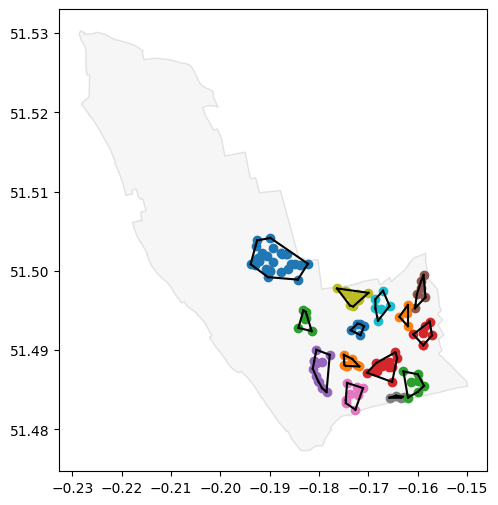

In [5]:
#Regionalise
#create convex hull
#Reference https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html
import scipy
import numpy
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt

#remove noise
remove = kc_wiki_with_summary[kc_wiki_with_summary['cluster'] == -1].index
kc_wiki_with_summary = kc_wiki_with_summary.drop(remove)
#select only necessary column
db_cl = kc_wiki_with_summary[["gt_lon",
                   "gt_lat",
                   "cluster"]]

#run convexhull for each clusters seperately
#create a list of convex hull
h = [] #for list of polygon coordinates from chull
import geopandas as gpd
#load boundary file for kc
kc_boundary = gpd.read_file('../../data/boundary_london/kc.shp')
# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
kc_boundary.to_crs(epsg=4326).plot(ax=ax,
                                  color= 'lightgrey', alpha= 0.2,
                                  edgecolor = '0.5')
for i in range(0,14):
    cluster_i = db_cl.loc[db_cl['cluster']==i]
    db_cl_i = cluster_i[["gt_lon", "gt_lat"]].to_numpy()
    ch_i = ConvexHull(db_cl_i)
    h.append(db_cl_i[ch_i.vertices,:].tolist())
    plt.plot(db_cl_i[:, 0],db_cl_i[:, 1],  'o')
    for simplex in ch_i.simplices:
        ploted=plt.plot(db_cl_i[simplex, 0], db_cl_i[simplex, 1],'k-')
#plt.savefig('../../docs/docs_wiki_clustering/dbscan_wiki_kc_reg.png')
#for generating polygon from ordered manner
#Ref: https://stackoverflow.com/questions/61740032/how-to-convert-convex-hull-vertices-into-a-geopandas-polygon
from shapely.geometry import MultiPoint
c_h = []
for hull in h:
    c_h.append(MultiPoint(hull).convex_hull)

print(c_h)


In [12]:
#Create sequence of data

In [6]:
#select only necessary column
db_cl = kc_wiki_with_summary[["gt_lon",
                   "gt_lat",
                   "cluster"]]
                    #"page_summary"]]
#create a function for centroid calculation
from shapely.geometry import Polygon
def centroid_calc (in_df):
    db_cl_i = in_df[["gt_lon", "gt_lat"]].to_numpy()
    ch_i = ConvexHull(db_cl_i)
    hull_indices = ch_i.vertices
    hull_pts = db_cl_i[hull_indices, :]
    #find the centroid of polygon
    p_i = Polygon(hull_pts)
    centroid_i = p_i.centroid      
    return centroid_i
        
cluster_centroid = pd.DataFrame(kc_wiki_with_summary.groupby(['cluster']).apply(centroid_calc))
cluster_centroid.rename(columns = {0:'poly_centroid'}, inplace = True)
cluster_centroid['gt_lon'] = cluster_centroid.poly_centroid.apply(lambda p: p.x)
cluster_centroid['gt_lat'] = cluster_centroid.poly_centroid.apply(lambda p: p.y)
cluster_centroid

C:\Users\smn18\AppData\Local\Temp\ipykernel_11608\3738718964.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_centroid = pd.DataFrame(kc_wiki_with_summary.groupby(['cluster']).apply(centroid_calc))


,poly_centroid,gt_lon,gt_lat
cluster,,,
0,POINT (-0.1885672996985039 51.501272524299594),-0.188567,51.501273
1,POINT (-0.1738169698802692 51.48850212209417),-0.173817,51.488502
2,POINT (-0.1829024175877831 51.49348535988295),-0.182902,51.493485
3,POINT (-0.1666260729608146 51.487731646245834),-0.166626,51.487732
4,POINT (-0.1794547859975268 51.48768831471137),-0.179455,51.487688
5,POINT (-0.1593850699809158 51.497183160387344),-0.159385,51.497183
6,POINT (-0.1731059784932263 51.48429593570582),-0.173106,51.484296
7,POINT (-0.1641776178633265 51.48408576304787),-0.164178,51.484086
8,POINT (-0.1732606592312659 51.496791962758174),-0.173261,51.496792


In [7]:
#join the clustered centroid data
kc_wiki_with_centroid = pd.merge(kc_wiki_with_summary, cluster_centroid, on=['cluster'])

In [10]:
#calculate distance from point to centroid and sort by shortest distance
import geopy
from geopy.distance import geodesic
def distance_calc(row):
    coords_1 = (row['gt_lat_x'], row['gt_lon_x'])
    coords_2 = (row['gt_lat_y'], row['gt_lon_y'])
    return geodesic(coords_1, coords_2).km
kc_wiki_with_centroid['distance'] = kc_wiki_with_centroid.apply(distance_calc, axis=1)
kc_wiki_with_centroid = kc_wiki_with_centroid.sort_values(by=['cluster', 'distance'], ascending = [True, True])

In [ ]:
#RUN LDA

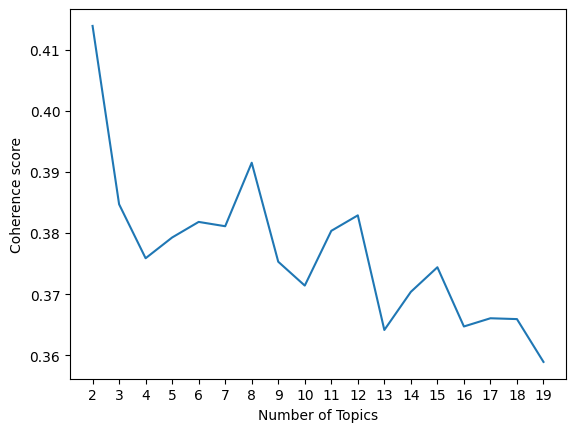

In [13]:
#calculate coherence value for differenct topic number
#Code inspired from https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920
#gensim reference: https://radimrehurek.com/gensim/models/coherencemodel.html
#https://radimrehurek.com/gensim/models/ldamodel.html
import gensim
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
# Create a corpus from a list of texts
dictionary = Dictionary(tag_list_dbscan)
corpus = [dictionary.doc2bow(text) for text in tag_list_dbscan]
coherence_values = []
def coherence_value(dictionary, texts, corpus, start, stop, step):
    for num_topics in range(start, stop, step):
        lda_model = LdaModel(corpus=corpus,
                              num_topics=num_topics)
        coherencemodel = CoherenceModel(model=lda_model,
                                        corpus=corpus,
                                        dictionary=dictionary,
                                        texts = texts,
                                        coherence='c_v')
        coherence_score = coherencemodel.get_coherence()
        coherence_values.append(coherence_score)

    return coherence_values

#run the function to find optimum number of topics
coherence_values = coherence_value(dictionary=dictionary, 
                                   corpus=corpus, 
                                   texts = tag_list_dbscan,
                                   start=2, 
                                   stop=20, 
                                   step=1)

#plot as graph
x = range(2, 20)
plt.plot(x, coherence_values)
plt.xticks(range(2,20))
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
#graph_t = '../../docs/docs_wiki_clustering/lda/topic_choice_wiki.png' 
#plt.savefig(graph_t)
plt.show()
    

In [14]:
#build lda with optimum topic number
lda_model_4topics = LdaModel(corpus=corpus, 
                      num_topics=6,
                      id2word = dictionary)
                      #per_word_topics=True)
#print the topics
#lda_model.print_topics()
lda_model_4topics.show_topics(num_words = 20)

[(0,
  '0.024*"street" + 0.018*"london" + 0.012*"kensington" + 0.011*"chelsea" + 0.010*"road" + 0.008*"house" + 0.006*"south" + 0.005*"square" + 0.005*"museum" + 0.005*"north" + 0.005*"royal" + 0.004*"place" + 0.004*"england" + 0.004*"listed" + 0.004*"building" + 0.004*"borough" + 0.004*"west" + 0.004*"built" + 0.004*"sloane" + 0.004*"school"'),
 (1,
  '0.025*"london" + 0.015*"road" + 0.015*"kensington" + 0.010*"museum" + 0.009*"street" + 0.008*"house" + 0.008*"chelsea" + 0.007*"south" + 0.006*"square" + 0.005*"royal" + 0.005*"gardens" + 0.004*"england" + 0.004*"north" + 0.004*"building" + 0.004*"west" + 0.004*"listed" + 0.004*"garden" + 0.003*"built" + 0.003*"station" + 0.003*"exhibition"'),
 (2,
  '0.018*"chelsea" + 0.016*"london" + 0.015*"street" + 0.013*"road" + 0.009*"kensington" + 0.007*"square" + 0.006*"house" + 0.005*"royal" + 0.005*"england" + 0.005*"south" + 0.005*"school" + 0.005*"hall" + 0.004*"gardens" + 0.004*"built" + 0.004*"cadogan" + 0.004*"building" + 0.004*"grade" + 

C:\Users\smn18\AppData\Local\Temp\ipykernel_7424\3216198002.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability',
C:\Users\smn18\AppData\Local\Temp\ipykernel_7424\3216198002.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability',
C:\Users\smn18\AppData\Local\Temp\ipykernel_7424\3216198002.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='probability',
C:\Users\smn18\AppData\Local\Temp\ipykernel_7424\3216198002.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remov

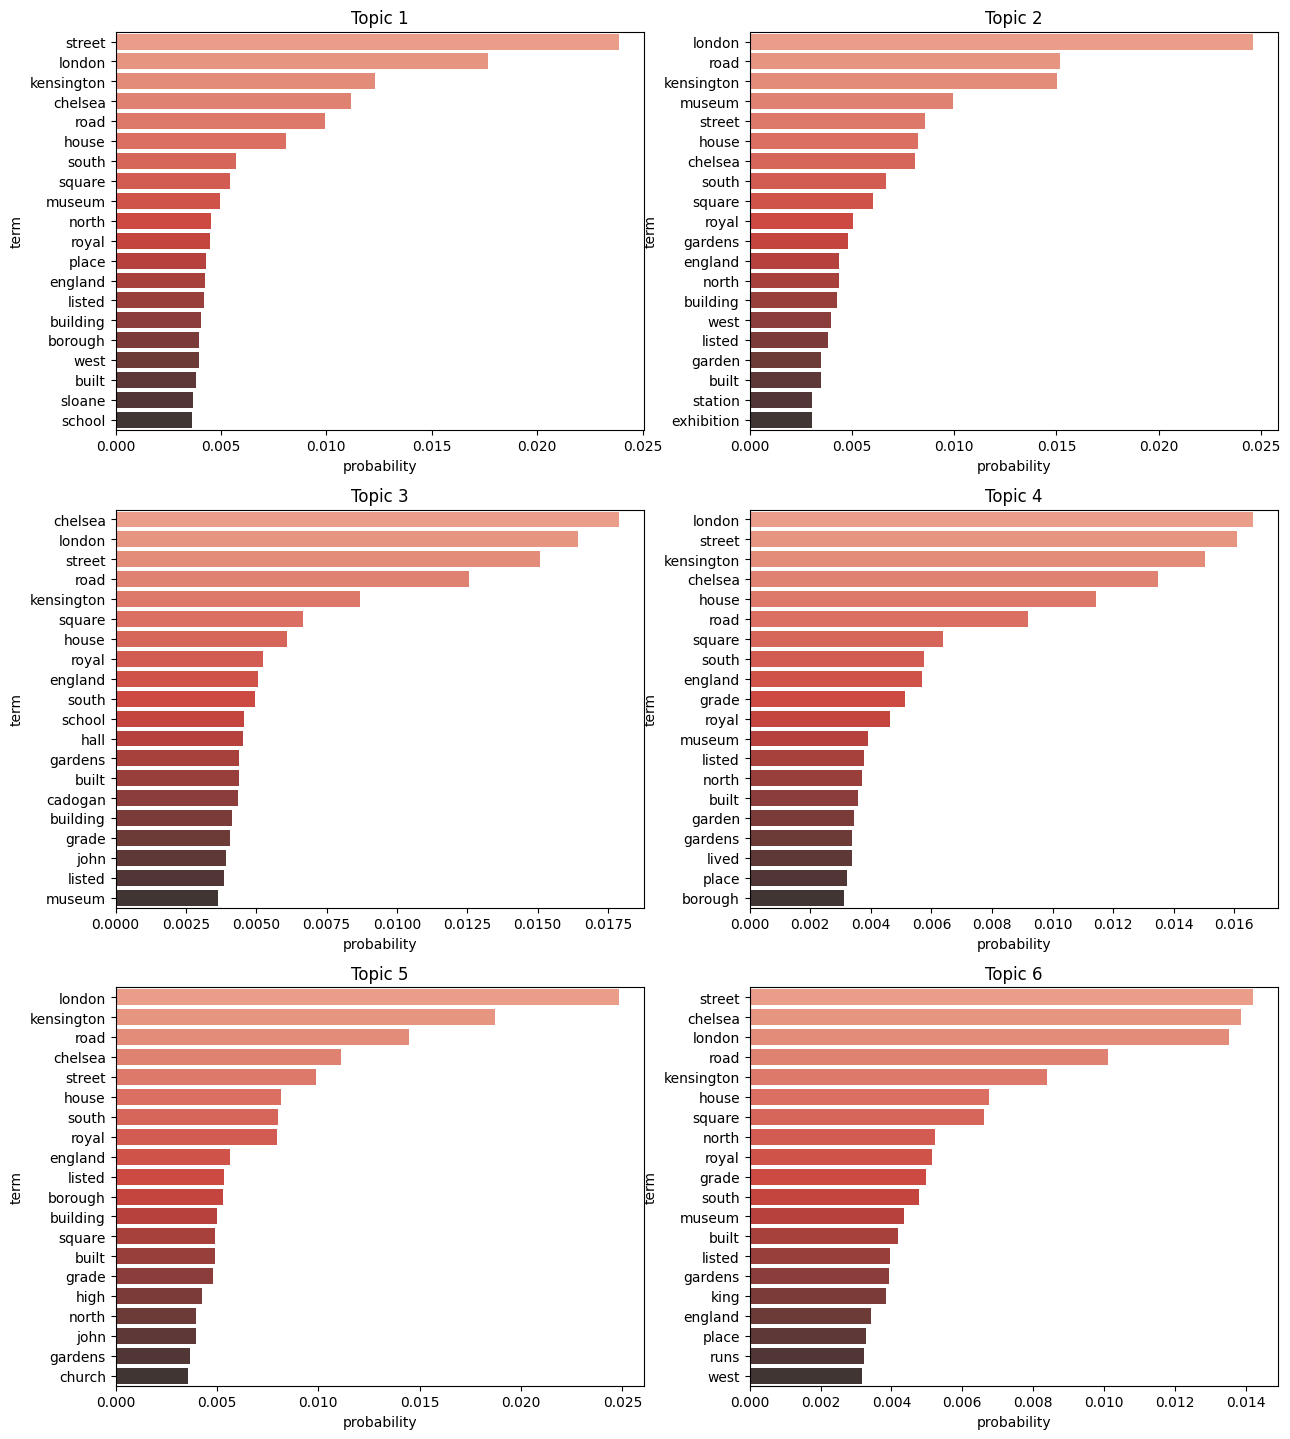

In [19]:
#visualise 
#!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
fig=plt.figure(figsize=(15,30))
fig_no = 0
for i in range(0,6):
    df=pd.DataFrame(lda_model_4topics.show_topic(i, topn = 20), 
                    columns=['term','probability']).set_index('term')
    plt.subplot(5,2,i+1)
    plt.title('Topic '+str(i+1))
    sns.barplot(x='probability',
                y=df.index, 
                data=df, 
                palette='Reds_d')
    plt.xlabel('probability')
    fig_no += 1
    

plt.show()

In [16]:
#Compute Perplexity
perplexity_lda = lda_model_4topics.log_perplexity(corpus)
print('\nPerplexity: ', perplexity_lda )  # a measure of how good the model is lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_4topics, 
                                     texts=tag_list_dbscan, 
                                     dictionary=dictionary, 
                                     coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.291669816566037

Coherence Score:  -0.3846042547628301


In [17]:
#Topic distribution for each dbscan cluster
all_topics = lda_model_4topics.get_document_topics(corpus)
num_docs = len(all_topics)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
colnames = ['Topic'+str(i+1) for i in range(0,6)]
all_topics_df = pd.DataFrame(all_topics_numpy, columns = colnames)
#find the dominant topic for each DBSCAN cluster
all_topics_df['Topic'] = all_topics_df[colnames].idxmax(axis=1)
all_topics_df

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic
0,0.000000,0.000000,0.000000,0.000000,0.999186,0.000000,Topic5
1,0.000000,0.000000,0.850584,0.144055,0.000000,0.000000,Topic3
2,0.000000,0.891916,0.000000,0.000000,0.106618,0.000000,Topic2
3,0.345878,0.000000,0.000000,0.083748,0.000000,0.565931,Topic6
4,0.000000,0.270881,0.000000,0.000000,0.727387,0.000000,Topic5
5,0.996711,0.000000,0.000000,0.000000,0.000000,0.000000,Topic1
6,0.089384,0.000000,0.000000,0.908877,0.000000,0.000000,Topic4
7,0.000000,0.000000,0.000000,0.000000,0.997220,0.000000,Topic5
8,0.000000,0.995196,0.000000,0.000000,0.000000,0.000000,Topic2
9,0.021411,0.973755,0.000000,0.000000,0.000000,0.000000,Topic2


In [18]:
##add c_h polygon coordinates
all_topics_df['geometry'] = c_h
#set index as column
all_topics_df['cluster'] = all_topics_df.index

In [20]:
#add topic labels
#Name the lda topics
def get_lda_topic_name(topic):
    if topic == 'Topic1':
        return 'Notable streets and roads '
    elif topic == 'Topic2':
        return 'Cultural hub'
    elif topic == 'Topic3':
        return 'Royal Residences'
    elif topic == 'Topic4':
        return 'Residential area'
    elif topic == 'Topic5':
        return 'Residential area'
    else:
        return 'Royal Residences'
all_topics_df['LDA_Topic_Wiki'] = all_topics_df['Topic'].apply(get_lda_topic_name)

In [21]:
all_topics_df

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic,geometry,cluster,LDA_Topic_Wiki
0,0.000000,0.000000,0.000000,0.000000,0.999186,0.000000,Topic5,"POLYGON ((-0.18432 51.498891, -0.19036667 51.4992, -0.19388889 51.50083333, -0.192866 51.503186, -0.192567 51.503838, -0.189875 51.504146, -0.18227778 51.50088889, -0.18432 51.498891))",0,Residential area
1,0.000000,0.000000,0.850584,0.144055,0.000000,0.000000,Topic3,"POLYGON ((-0.17186667 51.48793333, -0.1746 51.488, -0.1749 51.48816, -0.175 51.4894, -0.1733 51.48888889, -0.17186667 51.48793333))",1,Royal Residences
2,0.000000,0.891916,0.000000,0.000000,0.106618,0.000000,Topic2,"POLYGON ((-0.18150556 51.49239167, -0.1842 51.4928, -0.1832 51.495, -0.1827 51.4948, -0.18150556 51.49239167))",2,Cultural hub
3,0.345878,0.000000,0.000000,0.083748,0.000000,0.565931,Topic6,"POLYGON ((-0.1652 51.48597, -0.17029 51.48715, -0.1684 51.488375, -0.16454722 51.48971667, -0.1642 51.489, -0.1652 51.48597))",3,Royal Residences
4,0.000000,0.270881,0.000000,0.000000,0.727387,0.000000,Topic5,"POLYGON ((-0.1785 51.4847, -0.1794 51.4852, -0.1802 51.4861, -0.18129167 51.48764444, -0.181 51.4886, -0.18055556 51.49003611, -0.177845 51.489394, -0.1785 51.4847))",4,Residential area
5,0.996711,0.000000,0.000000,0.000000,0.000000,0.000000,Topic1,"POLYGON ((-0.16055556 51.49527778, -0.16019 51.49702, -0.15930556 51.49872222, -0.15883333 51.49947222, -0.15844 51.49667, -0.16055556 51.49527778))",5,Notable streets and roads
6,0.089384,0.000000,0.000000,0.908877,0.000000,0.000000,Topic4,"POLYGON ((-0.17264444 51.48248333, -0.17458889 51.48330556, -0.1746 51.4837, -0.17433 51.48586, -0.1711 51.4852, -0.17264444 51.48248333))",6,Residential area
7,0.000000,0.000000,0.000000,0.000000,0.997220,0.000000,Topic5,"POLYGON ((-0.16343 51.48398, -0.16573 51.48399, -0.1644 51.48425, -0.1627 51.4841, -0.16343 51.48398))",7,Residential area
8,0.000000,0.995196,0.000000,0.000000,0.000000,0.000000,Topic2,"POLYGON ((-0.1731 51.4955, -0.17376 51.49563, -0.17638889 51.49777778, -0.17 51.49722222, -0.1731 51.4955))",8,Cultural hub
9,0.021411,0.973755,0.000000,0.000000,0.000000,0.000000,Topic2,"POLYGON ((-0.168067 51.493696, -0.16859167 51.49528611, -0.16859444 51.496425, -0.167058 51.497489, -0.165711 51.495564, -0.168067 51.493696))",9,Cultural hub


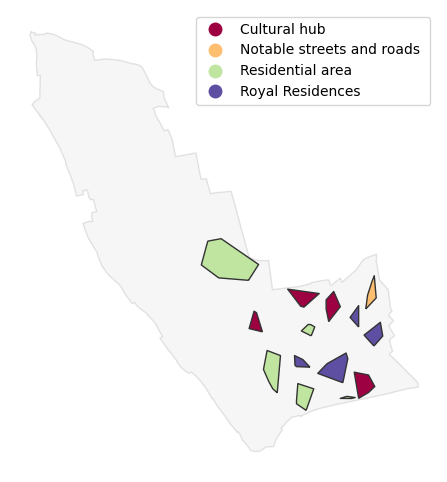

In [22]:
import geopandas as gpd
#Mapping
lda_cluster_gdf = gpd.GeoDataFrame(all_topics_df, geometry="geometry", crs='EPSG:4326')
#load boundary file for kc
kc_boundary = gpd.read_file('../../data/boundary_london/kc.shp')
# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
kc_boundary.to_crs(epsg=4326).plot(ax=ax,
                                  color= 'lightgrey', alpha= 0.2,
                                  edgecolor = '0.5')
lda_cluster_gdf.plot(column='LDA_Topic_Wiki', 
                      categorical = True  , 
                      edgecolor='0.2',
                      cmap='Spectral', 
                      ax=ax, 
                      legend = True
                      #legend_kwds={'label': "K-means Cluster", 'orientation': 'vertical'}
                     )
ax.set_axis_off()
map_k = '../../docs/docs_ohsome/all_Mar/kc_wiki_lda_map_nov.png'
plt.savefig(map_k)

0    Annotation(-0.166952, 51.4917, "{'museum', 'ga...
1    Annotation(-0.185697, 51.4991, "{'museum', 'ga...
2              Annotation(-0.197509, 51.5099, 'set()')
3         Annotation(-0.179455, 51.4877, "{'garden'}")
4    Annotation(-0.208126, 51.506, "{'diplomatic', ...
5    Annotation(-0.205241, 51.5145, "{'gallery', 'g...
6    Annotation(-0.193927, 51.5071, "{'gallery', 'd...
7         Annotation(-0.194743, 51.4893, "{'garden'}")
dtype: object

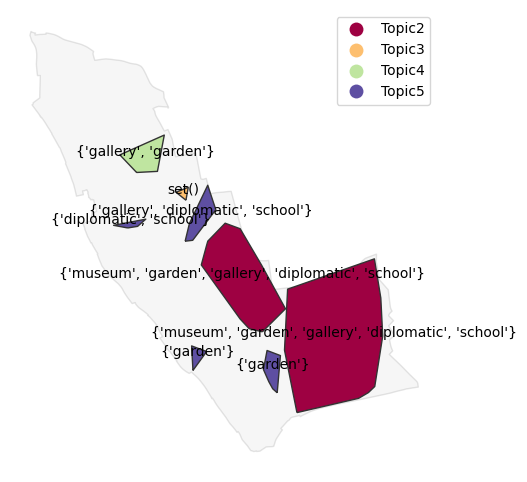

In [76]:
import geopandas as gpd
#Mapping
lda_cluster_gdf = gpd.GeoDataFrame(lda_cluster, geometry="geometry", crs='EPSG:4326')
#load boundary file for kc
kc_boundary = gpd.read_file('../../data/boundary_london/kc.shp')
# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
kc_boundary.to_crs(epsg=4326).plot(ax=ax,
                                  color= 'lightgrey', alpha= 0.2,
                                  edgecolor = '0.5')
lda_cluster_gdf.plot(column='Topic', 
                      categorical = True  , 
                      edgecolor='0.2',
                      cmap='Spectral', 
                      ax=ax, 
                      legend = True
                      #legend_kwds={'label': "K-means Cluster", 'orientation': 'vertical'}
                     )
ax.set_axis_off()
#map_k = '../../docs/docs_ohsome/all_Mar/kc_wiki_lda_map.png'
#plt.savefig(map_k)
#Add label
#Referred from https://stackoverflow.com/questions/68832737/how-to-add-both-name-and-number-description-on-geo-pandas-plot-in-python
lda_cluster_gdf.apply(lambda x: ax.annotate(text=x.Inf_Word, 
                                             xy=x.geometry.centroid.coords[0], 
                                             ha='center',
                                             color = "black"), axis=1)
#ax.set_title('',fontsize=20)